In [131]:
import pandas as pd
import nltk
import re
import html
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import AdaBoostClassifier

warnings.filterwarnings("ignore", message="Some weights of RobertaModel were not initialized from the model checkpoint")

In [88]:
def clean(text, lowercase=True, remove_html=True, remove_special_chars=True):
    if lowercase:
        text = text.lower()
    text = text.replace('user', '')
    if remove_html:
        text = html.unescape(text)
        text = re.sub(r'<.*?>', '', text)

    if remove_special_chars:
        text = re.sub(r'[^a-zA-Z\s.,!?;]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def get_roberta_embeddings(text, tokenizer, model, device):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state

    sentence_embedding = embeddings.mean(dim=1)

    return sentence_embedding[0].cpu().detach().numpy().tolist()

In [89]:
df = pd.read_csv('/kaggle/input/polyhope-iberlef-2025/en_train.csv')
df = df[['text','binary']]

le = LabelEncoder()
df['label'] = le.fit_transform(df['binary'])
df['text'] = df['text'].apply(clean)

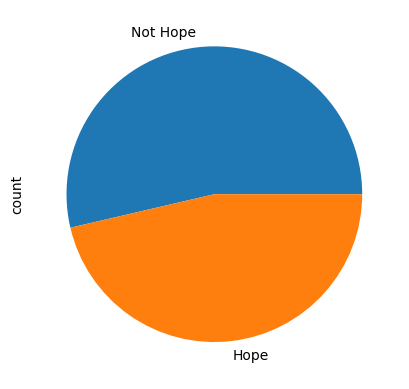

In [90]:
df['binary'].value_counts().plot.pie()
plt.show()

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

tqdm.pandas()
df['embedding'] = df['text'].progress_apply(lambda x: get_roberta_embeddings(x, tokenizer, model, device))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5233/5233 [00:43<00:00, 119.00it/s]


In [92]:
embedding_df = pd.DataFrame(df['embedding'].tolist(), columns=[f'embedding_{i}' for i in range(len(df['embedding'][0]))])

df = pd.concat([df, embedding_df], axis=1)

In [101]:
X = df.iloc[:, 4:]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [102]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       725
           1       0.81      0.84      0.83       845

    accuracy                           0.81      1570
   macro avg       0.81      0.81      0.81      1570
weighted avg       0.81      0.81      0.81      1570



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
svc = SVC()

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       725
           1       0.76      0.85      0.80       845

    accuracy                           0.77      1570
   macro avg       0.78      0.77      0.77      1570
weighted avg       0.77      0.77      0.77      1570



In [106]:
lgbm = LGBMClassifier()

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1962, number of negative: 1701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 3663, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535627 -> initscore=0.142748
[LightGBM] [Info] Start training from score 0.142748
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       725
           1       0.78      0.82      0.80       845

    accuracy                           0.78      1570
   macro avg       0.78      0.77      0.77      1570
weighted avg       0.78      0.78      0.78      1570



In [132]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=3, callbacks=[early_stopping])

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       725
           1       0.81      0.84      0.82       845

    accuracy                           0.81      1570
   macro avg       0.81      0.80      0.80      1570
weighted avg       0.81      0.81      0.81      1570



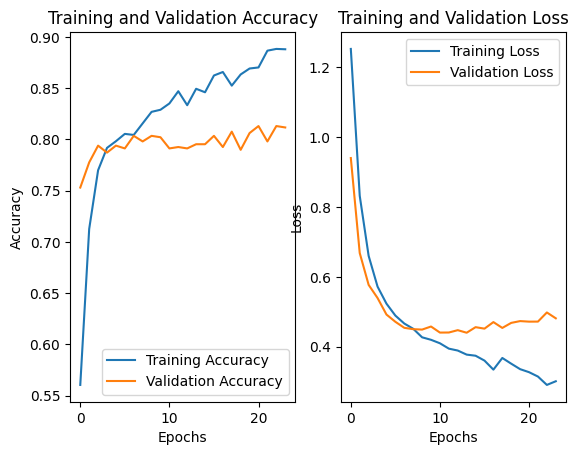

In [133]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [136]:
adb = AdaBoostClassifier()

adb.fit(X_train, y_train)

y_pred = adb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       725
           1       0.75      0.76      0.76       845

    accuracy                           0.74      1570
   macro avg       0.73      0.73      0.73      1570
weighted avg       0.74      0.74      0.74      1570



# Testing

In [134]:
dev_df = pd.read_csv('/kaggle/input/polyhope-iberlef-2025/en_dev.csv')

dev_df = dev_df[['text','binary']]

dev_df['label'] = le.transform(dev_df['binary'])
dev_df['text'] = dev_df['text'].apply(clean)

In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

tqdm.pandas()
dev_df['embedding'] = dev_df['text'].progress_apply(lambda x: get_roberta_embeddings(x, tokenizer, model, device))

embedding_df = pd.DataFrame(dev_df['embedding'].tolist(), columns=[f'embedding_{i}' for i in range(len(dev_df['embedding'][0]))])

dev_df = pd.concat([dev_df, embedding_df], axis=1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1902/1902 [00:16<00:00, 117.73it/s]


In [140]:
y_pred = lr.predict(dev_df.iloc[:, 4:])

print(classification_report(dev_df['label'], y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77       899
           1       0.79      0.81      0.80      1003

    accuracy                           0.78      1902
   macro avg       0.78      0.78      0.78      1902
weighted avg       0.78      0.78      0.78      1902

